# Avaliação Final
Aluno: Carlos Dip
___

**Aviso**, as redes usadas são um pouco lentas para treinar (entre 1h30min e 2h30min no total), contudo, no repositório os arquivos já estão salvos para reduzir esse processo a leitura de disco. No total, contando com a leitura do cache das redes, tudo deve rodar em uns 10min.

___

Dataset escolhido: [DBPedia](https://www.kaggle.com/datasets/danofer/dbpedia-classes?select=DBP_wiki_data.csv)

DBPedia é um dataset de artigos da wikipedia, já limpos e categorizados taxonomicamente. Existem 3 níveis de especificidade oferecidos (l1, l2, l3), com 9, 70 e 219 classes respectivamente.

Por questão de interpretabilidade e de quantidade de dados, achei mais interessante trabalhar com o nível l1, com 9 classes.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, LSTM, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os

In [2]:
df = pd.read_csv('DBP_wiki_data.csv').drop(['l2','l3','wiki_name'],axis=1)
df

,text,l1,word_count
0,The 1994 Mindoro earthquake occurred on Novemb...,Event,59
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event,68
2,The 1941 Colima earthquake occurred on April 1...,Event,194
3,The 1983 Coalinga earthquake occurred on May 2...,Event,98
4,The 2013 Bushehr earthquake occurred with a mo...,Event,61
...,...,...,...
342776,WCSH is the NBC-affiliated television station ...,Agent,198
342777,Al Jazeera America (AJAM) was an American basi...,Agent,226
342778,"CJOH-DT, VHF channel 13, is a CTV owned-and-op...",Agent,234
342779,NTTV (North Texas Television) is a student tel...,Agent,126


In [3]:
(df['l1'].value_counts(), df['l1'].value_counts(normalize=True))

(Agent             177341
 Place              65128
 Species            31149
 Work               29832
 Event              27059
 SportsSeason        8307
 UnitOfWork          2497
 TopicalConcept      1115
 Device               353
 Name: l1, dtype: int64,
 Agent             0.517359
 Place             0.189999
 Species           0.090871
 Work              0.087029
 Event             0.078940
 SportsSeason      0.024234
 UnitOfWork        0.007285
 TopicalConcept    0.003253
 Device            0.001030
 Name: l1, dtype: float64)

Como é possível observar, os dados não estão muito bem distribuídos entre as 9 categorias. Para remediar isso, decidi alterar a perspectiva do problema, para classificação binária: Agent vs Not-Agent 

In [4]:
df.loc[df['l1'] == 'Agent'].sample(10)

,text,l1,word_count
307994,KBC Bank N.V. is a Belgian universal multi-cha...,Agent,282
242750,Kenneth Maumalo (born 16 July 1994) is a profe...,Agent,30
268257,"William Louis Ayres (1874–November 30, 1947), ...",Agent,89
191416,Louis Byron Tolley (1889 – 30 April 1959) was ...,Agent,120
201246,"Ibrahim Namo Ibrahim (born October 1, 1937) is...",Agent,85
283848,"Takumi Yamazaki (山崎 たくみ Yamazaki Takumi, born ...",Agent,23
295912,The Malta Railway was the only railway line ev...,Agent,53
175248,Holly Martin Smith (also known as Holly S. Gol...,Agent,176
274987,"James \""Jim\"" Traynor (born 27 September 1953)...",Agent,112
265639,"L. Yves Fortier, PC CC OQ QC, Ad.E. (born Sept...",Agent,74


Um Agent é, essencialmente, uma pessoa, entidade ou instituição. Acima, alguns exemplos de artigos sobre Agents.

In [5]:
df.loc[df['l1'] != 'Agent', 'l1'] = '0'
df.loc[df['l1'] == 'Agent', 'l1'] = '1'
df['l1'].value_counts()

1    177341
0    165440
Name: l1, dtype: int64

In [6]:
sample = ' '.join(df['text'][:3])
def treat(sample: str):
    sample = re.sub('\{.*\}','',sample)
    # sample = re.sub('\=.*\=','',sample)
    sample = re.sub('`','',sample)
    sample = re.sub(r'[^\w\s]','',sample)
    return sample.lower()
print("Treatment example:\n{0}\n=>\n{1}".format(sample[:100], treat(sample[:100])))
df['treated_text'] = df['text'].apply(treat)
df

Treatment example:
The 1994 Mindoro earthquake occurred on November 15 at 03:15 local time near Mindoro, the Philippine
=>
the 1994 mindoro earthquake occurred on november 15 at 0315 local time near mindoro the philippine


,text,l1,word_count,treated_text
0,The 1994 Mindoro earthquake occurred on Novemb...,0,59,the 1994 mindoro earthquake occurred on novemb...
1,The 1917 Bali earthquake occurred at 06:50 loc...,0,68,the 1917 bali earthquake occurred at 0650 loca...
2,The 1941 Colima earthquake occurred on April 1...,0,194,the 1941 colima earthquake occurred on april 1...
3,The 1983 Coalinga earthquake occurred on May 2...,0,98,the 1983 coalinga earthquake occurred on may 2...
4,The 2013 Bushehr earthquake occurred with a mo...,0,61,the 2013 bushehr earthquake occurred with a mo...
...,...,...,...,...
342776,WCSH is the NBC-affiliated television station ...,1,198,wcsh is the nbcaffiliated television station f...
342777,Al Jazeera America (AJAM) was an American basi...,1,226,al jazeera america ajam was an american basic ...
342778,"CJOH-DT, VHF channel 13, is a CTV owned-and-op...",1,234,cjohdt vhf channel 13 is a ctv ownedandoperate...
342779,NTTV (North Texas Television) is a student tel...,1,126,nttv north texas television is a student telev...


Agora que os dados estão tratados, façamos a separação treino_teste.

In [7]:
X_full = list(df['treated_text'])
y_full = np.array(df[['l1']]).astype(int)
print(f'len(reviews)={len(X_full)}, labels.shape={y_full.shape}')
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=1337)
# print(y_test[:2])

len(reviews)=342781, labels.shape=(342781, 1)


Como baseline para comparação entre modelos, começarei com um simples Naive Bayes binário (Bernoulli NB), que não usa N-gramas, e considera stopwords, com um vocabulário de 2000 palavras.

In [8]:
vectorizer = CountVectorizer(binary=True, max_features=2000, stop_words=stopwords)
X_train_vec = vectorizer.fit_transform(X_train)

/home/user/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


In [9]:
model = BernoulliNB()
model.fit(X_train_vec, y_train)
nb_pred = model.predict(vectorizer.transform(X_test))
print(classification_report(y_test, nb_pred))

/home/user/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.85      0.89      0.87     41334
           1       0.89      0.85      0.87     44362

    accuracy                           0.87     85696
   macro avg       0.87      0.87      0.87     85696
weighted avg       0.87      0.87      0.87     85696



O modelo parece ter produzidos resultados bons, com uma acurácia de 87%, num conjunto de dados com uma distribuição de aproximadamente 50% em cada classe.

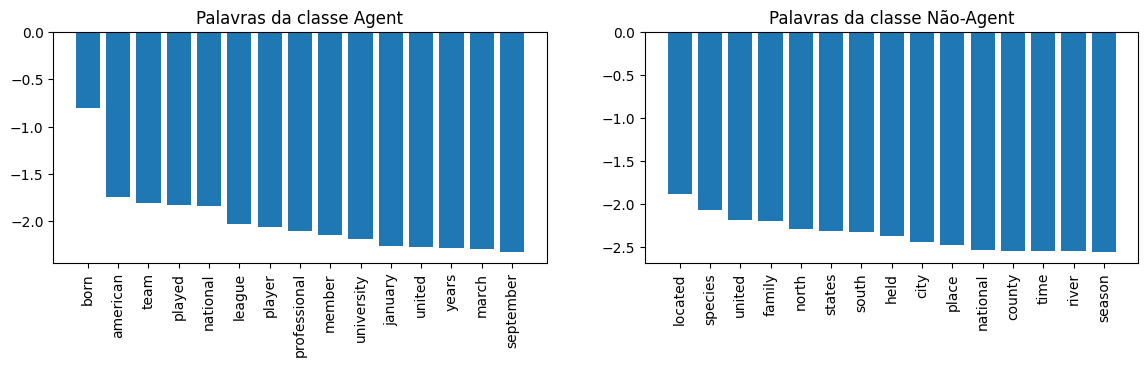

In [10]:
vocab = vectorizer.vocabulary_
# Probabilidades
palavras_agent = []
palavras_other = []
for t in vocab.keys():
    prob_agent = model.feature_log_prob_[1, vocab[t]]
    palavras_agent.append( (prob_agent, t) )
    prob_other = model.feature_log_prob_[0, vocab[t]]
    palavras_other.append( (prob_other, t) )
    
tuplas_ordenadas = sorted(palavras_agent, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

fig = plt.figure(figsize=(14,3))
n_palavras = 15
eixo_x = np.arange(n_palavras)
ax1 = fig.add_subplot(1,2,1)
ax1.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
ax1.set_title("Palavras da classe Agent")
ax1.set_xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)

# Mostrando num gráfico
tuplas_ordenadas = sorted(palavras_other, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
ax2 = fig.add_subplot(1,2,2)
ax2.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
ax2.set_xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=90)
ax2.set_title("Palavras da classe Não-Agent")
fig.show()

Acima, os gráficos indicam a relevância de palavras para as classes para o modelo Naive Bayes ($P(Palavra|Classe)$) 

Como é possível observar, o modelo encontrou algumas palavras que fazem bastante sentido. Agents, de maneira geral, nascem em algum momento, então a palavra born, assim como vários meses, e nacionalidades são termos que provavelmente são associados a essa classe. Ao mesmo tempo, coisas que não são pessoas, frequentemente são coisas ou lugares, que apresentam características como posicionamento (south, north, located, etc.) e níveis hierarquicos como states, city, country, etc.

Em seguida, um modelo mais elaborado, seria uma rede neural simples, que simplesmente cria um embedding para o espaço de palavras.

In [11]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

2022-06-10 12:58:38.016115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:58:38.031585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:58:38.032367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 12:58:38.033796: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

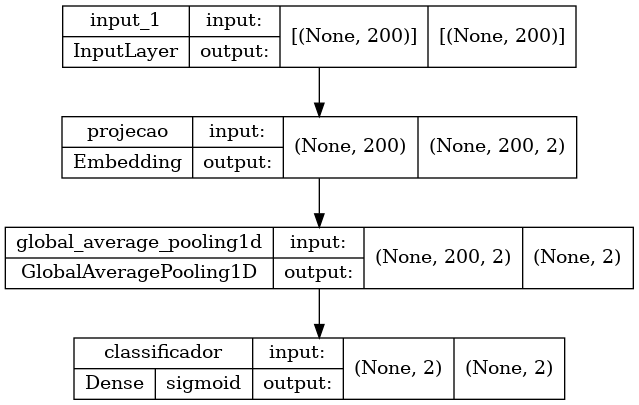

In [12]:
def rede_neural_classificar_por_palavra(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

try:
  rede_neural = load_model('./rede_neural_simples')
except Exception:
  rede_neural = rede_neural_classificar_por_palavra(200, 2)
  rede_neural.compile(optimizer='adam', loss='mse')
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
  history = rede_neural.fit(pad_sequences(sequences,maxlen=200), y_train, epochs=500, validation_split=0.2, callbacks=es)
  rede_neural.save('./rede_neural_simples')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [13]:
# Sadly can only show history if you run fit (takes 15min)
# plt.figure(figsize=(7,2))
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Épocas')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [14]:
def unencode(tup: tuple):
    if tup[0] < tup[1]:
        return 0
    return 1

y_est = rede_neural.predict(pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200))
print(classification_report(y_test, list(map(unencode,y_est))))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     41334
           1       0.92      0.91      0.92     44362

    accuracy                           0.91     85696
   macro avg       0.91      0.91      0.91     85696
weighted avg       0.91      0.91      0.91     85696



Pelos resultados acima, a rede já superou o Naive Bayes em aproximadamente de 44%, (erro de 13% para 9%).

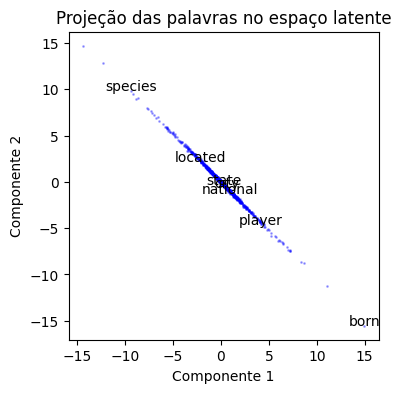

In [15]:
w = rede_neural.get_layer('projecao').get_weights()
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in "born player national city state located species".split():
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

Acima é possível analisar algumas das palavras no espaço latente de embeddings, onde palavras mais distantes da origem (0,0) são mais importantes para o modelo, no processo de descisão da categoria. Palavras como born e species são bastante decisivas para determinar a classe das sequências.

Para entender melhor como os modelos estão se comportando, escrevi alguns exemplos (100% inventados) para testar a capacidade de prever dos modelos.

In [16]:
def predict_label(phrase: str):
    test = pad_sequences(tokenizer.texts_to_sequences([treat(phrase)]),maxlen=200)
    pred = rede_neural.predict(test)
    x_nb = vectorizer.transform([phrases[0]]).toarray()
    nb = model.predict(x_nb)[0]
    return f'"{treat(phrase)}" \n\tNN: \n\tlabel: {unencode(list(pred[0]))} {list(pred[0])} \n\tNB: \n\tlabel: {nb}'

phrases = [
    "Rene descartes was a mathematician in the 18th century, who studied algebra and geometry.",
    "Iceland is a country that is very cold and has a high latitude.",
    "Football is a sport, considered by many to be a barbaric attempt to grasp at humanity's innate violent tendencies, which has some semblance of strategy, but really comes down to big strong guys running fast and permanently injuring themselves.",
    "Gengis Khan was the last of the Khans of the mongolian empire, and is considered to have been one of the most powerful people in antiquity. His indirect descendants number in the hundreds of millions just a few hundred years after his passing.",
]

[print(x) for x in list(map(predict_label, phrases))];

"rene descartes was a mathematician in the 18th century who studied algebra and geometry" 
	NN: 
	label: 1 [0.7713039, 0.77087176] 
	NB: 
	label: 0
"iceland is a country that is very cold and has a high latitude" 
	NN: 
	label: 1 [0.36711317, 0.3668511] 
	NB: 
	label: 0
"football is a sport considered by many to be a barbaric attempt to grasp at humanitys innate violent tendencies which has some semblance of strategy but really comes down to big strong guys running fast and permanently injuring themselves" 
	NN: 
	label: 0 [0.060690887, 0.060725253] 
	NB: 
	label: 0
"gengis khan was the last of the khans of the mongolian empire and is considered to have been one of the most powerful people in antiquity his indirect descendants number in the hundreds of millions just a few hundred years after his passing" 
	NN: 
	label: 1 [0.77296, 0.7729164] 
	NB: 
	label: 0


Como podemos observar, a rede neural conseguiu identificar bem os exemplos que falam sobre pessoas, enquanto o naive bayes não conseguiu fazer nenhuma previsão positiva. Como o naive bayes depende muito de palavras já conhecidas, é possível que não tenha achado palavras suficientes no seu vocabulário para fazer previsões boas.

Finalmente, um possível problema do modelo de rede neural que temos até então, é que ele não considera a sequência de palavras, ou seja, a ordem das palavras não importa para a descisão. Para remediar isso, pode-se tentar usar uma rede com memória, ou, recorrente (RNN), como uma LSTM.

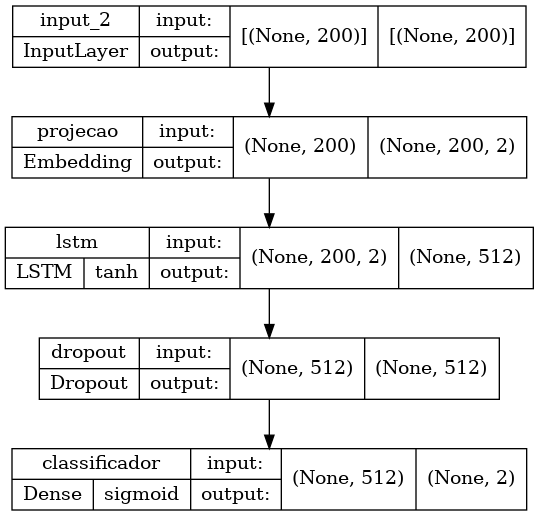

In [17]:
def rede_neural_lstm(input_dims, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = LSTM(512) (x)
  x = Dropout(0.2) (x)
  y = Dense(dim_out, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

try:
  rede_neural_lstm = load_model('./rede_neural_lstm')
except Exception:
  rede_neural_lstm = rede_neural_lstm(200, 2)
  rede_neural_lstm.compile(optimizer='adam', loss='mse')
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
  history = rede_neural_lstm.fit(pad_sequences(sequences,maxlen=200), y_train, epochs=500, validation_split=0.2, callbacks=es)
  rede_neural_lstm.save('./rede_neural_lstm')
plot_model(rede_neural_lstm, show_shapes=True, show_layer_activations=True)

In [18]:
# Fit takes 1h, no history either
# plt.figure(figsize=(7,2))
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.xlabel('Épocas')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

In [19]:
y_est = rede_neural_lstm.predict(pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200))
print(classification_report(y_test, list(map(unencode,y_est))))

2022-06-10 12:59:01.190693: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


              precision    recall  f1-score   support

           0       0.71      0.81      0.76     41334
           1       0.80      0.69      0.74     44362

    accuracy                           0.75     85696
   macro avg       0.76      0.75      0.75     85696
weighted avg       0.76      0.75      0.75     85696



O score acima é bastante baixo. Na realidade, é ainda pior que o Naive Bayes (Baseline). Abaixo, vamos investigar mais a fundo esse resultado.

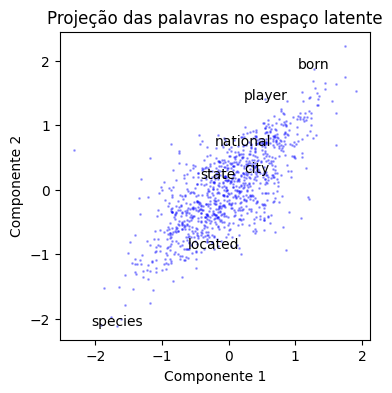

In [20]:
w = rede_neural_lstm.get_layer('projecao').get_weights()
# Visualização: onde foi parar cada palavra?
v_ = rede_neural_lstm.get_layer('projecao').get_weights()[0]

#proj = PCA(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in "born player national city state located species".split():
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

O espaço latente ainda apresenta alguns sinais positivos de entendimento do contexto, porém está mais disperso, como se a rede estivesse ainda bastante confusa sobre o que está acontecendo.

In [21]:
for phrase in phrases:
    test = pad_sequences(tokenizer.texts_to_sequences([treat(phrase)]),maxlen=200)
    pred = rede_neural_lstm.predict(test)
    print(f'"{treat(phrase)}" \n\tNN: \n\tlabel: {unencode(list(pred[0]))} {list(pred[0])}')


"rene descartes was a mathematician in the 18th century who studied algebra and geometry" 
	NN: 
	label: 0 [0.9899659, 0.99004537]
"iceland is a country that is very cold and has a high latitude" 
	NN: 
	label: 0 [0.10542112, 0.10842471]
"football is a sport considered by many to be a barbaric attempt to grasp at humanitys innate violent tendencies which has some semblance of strategy but really comes down to big strong guys running fast and permanently injuring themselves" 
	NN: 
	label: 0 [0.0006772113, 0.0007107296]
"gengis khan was the last of the khans of the mongolian empire and is considered to have been one of the most powerful people in antiquity his indirect descendants number in the hundreds of millions just a few hundred years after his passing" 
	NN: 
	label: 0 [0.9661749, 0.9663703]


Nas previsões em textos inventados, a rede apresentou resultados bastante tendenciosos para a classe "Não-Agent", porém isso ocorre com valores muito semelhantes nas duas saídas. E note que, se aplicarmos uma função de decisão simples (classe = 1 se média dos valores for > 0.5, ele teria acertado dois casos ('rene descartes' e 'gengis khan') como 1, e ainda acertaria o caso do 'football' como 0).

Abaixo, fornecemos uma sequência do conjunto de treinamento, para testar como é a performance no conjunto de treino.

In [22]:
phrase = X_train[0]
print(phrase)
print(f'Gabarito: ', y_train[0])
test = pad_sequences(tokenizer.texts_to_sequences([treat(phrase)]),maxlen=200)
pred = rede_neural_lstm.predict(test)
print(f'"{treat(phrase)}" \n\tNN: \n\tlabel: {unencode(list(pred[0]))} {list(pred[0])}')

columbus city center known locally as city center was a 1200000squarefoot 110000 m2 threelevel shopping center in columbus ohio it was located in the citys downtown near the ohio state capitol next to the ohio theatre and connected to a hyatt hotel the mall had a large parking structure attached that despite the malls closure in 2009 is still used extensively by downtown workers at the time of its opening city center was central ohios largest and most upscale shopping mall however a combination of factors would soon strip it of this status
Gabarito:  [0]
"columbus city center known locally as city center was a 1200000squarefoot 110000 m2 threelevel shopping center in columbus ohio it was located in the citys downtown near the ohio state capitol next to the ohio theatre and connected to a hyatt hotel the mall had a large parking structure attached that despite the malls closure in 2009 is still used extensively by downtown workers at the time of its opening city center was central ohios

A partir da observação acima, vale testar se usando um decisor diferente de argmax ($média > 1/2$) pode oferecer um resultado melhor.

In [23]:
def unencode_clever(tup: tuple):
    # try clever unencode analysis
    if (tup[0] + tup[1])>0.5:
        return 1
    return 0

y_est = rede_neural_lstm.predict(pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200))
y_est_lstm = list(map(unencode_clever,y_est))
print(classification_report(y_test, y_est_lstm))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     41334
           1       0.97      0.98      0.98     44362

    accuracy                           0.98     85696
   macro avg       0.98      0.98      0.98     85696
weighted avg       0.98      0.98      0.98     85696



Surpreendentemente, os resultados com a nova função de decisão são muito melhores, com acurácia de 98%. Só por curiosidade, vale testar esse método no modelo anterior, que parecia exibir um comportamento semelhante.

In [24]:
y_est = rede_neural.predict(pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200))
y_est_simple = list(map(unencode_clever,y_est))
print(classification_report(y_test, y_est_simple))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     41334
           1       0.94      0.98      0.96     44362

    accuracy                           0.95     85696
   macro avg       0.96      0.95      0.95     85696
weighted avg       0.96      0.95      0.95     85696



Bom, não ficou tão bom quanto a LSTM nesse caso. Como o treshold de 0.5 foi bastante bem sucedido, talvez seja bom usar um modelo simples de classificação, para determinar o treshold com melhor acurácia.

In [25]:
rfc_lstm = RandomForestClassifier(n_estimators = 50, n_jobs=-1, random_state=42, criterion='entropy', max_depth=4)
rfc_lstm.fit(rede_neural_lstm.predict(pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)), y_train.ravel())
print(rfc_lstm.feature_importances_)

2022-06-10 13:00:18.721821: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205668000 exceeds 10% of free system memory.


[0.53859907 0.46140093]


In [26]:
rfc_simple = RandomForestClassifier(n_estimators = 50, n_jobs=-1, random_state=42, criterion='entropy', max_depth=4)
rfc_simple.fit(rede_neural.predict(pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)), y_train.ravel())
print(rfc_simple.feature_importances_)

2022-06-10 13:01:43.973201: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205668000 exceeds 10% of free system memory.


[0.53770032 0.46229968]


In [27]:
def make_predictions_smart(rede : Model, rfc: RandomForestClassifier, X):
    p = rfc.predict(rede_neural_lstm.predict(pad_sequences(tokenizer.texts_to_sequences(X), maxlen=200)))
    return p

y_pred_lstm = make_predictions_smart(rede_neural_lstm, rfc_lstm, X_test)
print(y_pred_lstm.shape)

y_pred_simple = make_predictions_smart(rede_neural, rfc_simple, X_test)
print(y_pred_simple.shape)

(85696,)
(85696,)


In [28]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     41334
           1       0.98      0.98      0.98     44362

    accuracy                           0.98     85696
   macro avg       0.98      0.98      0.98     85696
weighted avg       0.98      0.98      0.98     85696



In [29]:
print(classification_report(y_test, y_pred_simple))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     41334
           1       0.98      0.97      0.98     44362

    accuracy                           0.98     85696
   macro avg       0.98      0.98      0.98     85696
weighted avg       0.98      0.98      0.98     85696



Parece que com a ajuda do Random forest, a rede simples conseguiu atingir um score semelhante a rede LSTM antes. Isso é bastante impressionante, considerando que essa rede treina em 1/3 do tempo, e faz as predições mais rapidamente também.

Em seguida, vêem-se as curvas ROC-AUC para análise da qualidade do modelo. 

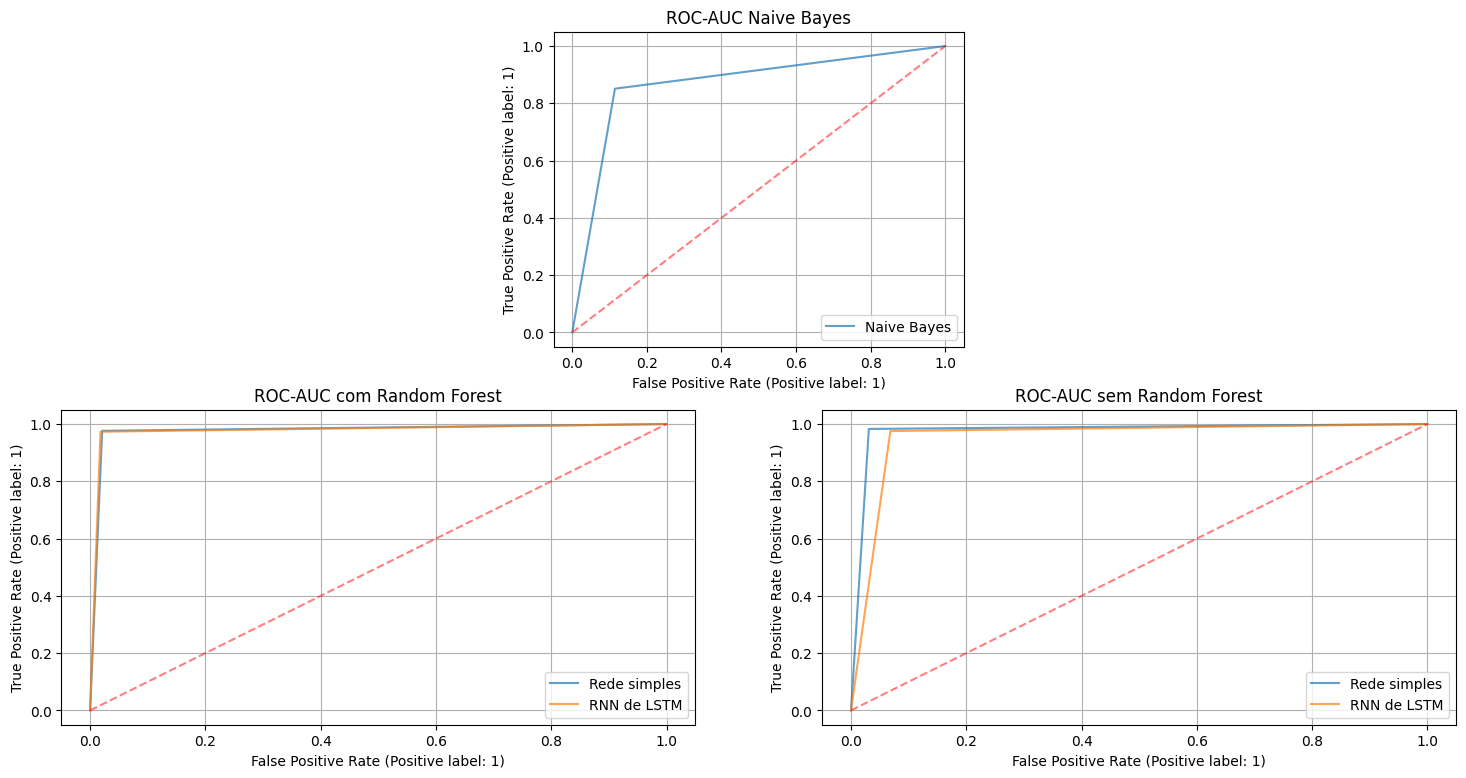

In [30]:
fig = plt.figure(figsize=(18,9))
ax3 = fig.add_subplot(232)
RocCurveDisplay.from_predictions(y_test, nb_pred, ax=ax3, label="Naive Bayes",alpha=0.7)
ax3.plot([0,1],[0,1], label='Random Guess', c="red", alpha=0.5, ls='--')
ax3.set_title("ROC-AUC Naive Bayes")
ax3.grid(True)

ax = fig.add_subplot(223)
RocCurveDisplay.from_predictions(y_test, y_pred_lstm, ax=ax, label="Rede simples",alpha=0.7)
RocCurveDisplay.from_predictions(y_test, y_pred_simple, ax=ax, label="RNN de LSTM", alpha=0.7)
ax.plot([0,1],[0,1], label='Random Guess', c="red", alpha=0.5, ls='--')
ax.set_title("ROC-AUC com Random Forest")
ax.grid(True)

ax2 = fig.add_subplot(224)
RocCurveDisplay.from_predictions(y_test, y_est_lstm, ax=ax2, label="Rede simples",alpha=0.7)
RocCurveDisplay.from_predictions(y_test, y_est_simple, ax=ax2, label="RNN de LSTM", alpha=0.7)
ax2.plot([0,1],[0,1], label='Random Guess', c="red", alpha=0.5, ls='--')
ax2.set_title("ROC-AUC sem Random Forest")
ax2.grid(True)
# ax2 = fig.add_subplot(122)
# ax2.set_title()
fig.show();

As curvas ROC-AUC ilustram o que eu expliquei acima, o Naive Bayes não atingiu um score muito alto, sem o Random forest, aplicando o threshold de 0.5, a rede simples perde por alguns pontos percentuais da LSTM, e com o Random Forest as duas ficam quase iguais em termos de score.

## Conclusão:

O dataset encontrado apresenta algumas características interessantes, como a distribuição das classes, e a dificuldade variável.

Durante os testes, foram construídos três modelos, o primeiro que serviu de baseline foi um Bernoulli Naive Bayes, que obteve uma performance razoável, e encontrou bem palavras que identificam os grupos. Em seguida uma rede neural simples, apenas com embeddings e um global average pooling, que foi capaz de obter um score muito bom, e apresentou um espaço latente de embeddings muito claro e interessante. Por fim, uma rede recorrente, capaz de analisar sequências de palavras no tempo, para entender construções temporais nas sequências, que apresentou o pior resultado de todos os modelos.

Porém, observando uma peculiaridade dos resultados, foi possível alterar a função de decisão da rede, e obter uma acurácia extremamente boa, cerca de 6.5x melhor que o baseline.

Nesse caso, como foi usada a função de ativação sigmóide para o decisor, parece que as redes ficaram muito indecisas entre os dois nós de saída, mas muito capazes quando os dois nós são analisados não como competidores, mas como apontadores em conjunto de qual classe é a mais provável.

Por conta disso, um simples descisor usando a média das duas saídas obteve um score vastamente superior. E em seguida foi testado um modelo com Random Forest Classifier usando a saída da rede neural, para tentar otizimizar os pesos das duas saídas, o que melhorou um pouco o score das duas.

Como visto nas curvas ROC-AUC, não existe muita diferença de score entre o LSTM e o Embedding simples. Contudo, devo dizer que dadas essas duas opções, o modelo de Embedding simples parece melhor, já que apresenta score quase igual, porém é mais leve, simples e rápido, e acima de tudo, é muito mais explicável, por conta da visibilidade do espaço latente e da sua simplicidade.

